In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
import re, datetime

from IPython.display import display, display_markdown

In [2]:
stock_list = pd.read_csv('../data/stock_list.csv.gz')
articles = pd.read_csv('../data/nikkei_article.csv.gz')

stock_list['Local Code'] = stock_list['Local Code'].astype(str)
stock_list.rename(columns={'Local Code':'stock_code'}, inplace=True)
articles.rename(columns={'company_g.stock_code':'stock_code'}, inplace=True)
articles['publish_datetime'] = pd.to_datetime(articles['publish_datetime'])

In [3]:
display(stock_list.head(3))
display(articles.head(3))

prediction_target  Effective Date stock_code              Name (English)  \
0               True        20201230       1301            KYOKUYO CO.,LTD.   
1               True        20201230       1332   Nippon Suisan Kaisha,Ltd.   
2               True        20201230       1333  Maruha Nichiro Corporation   

           Section/Products  33 Sector(Code)  \
0  First Section (Domestic)               50   
1  First Section (Domestic)               50   
2  First Section (Domestic)               50   

                     33 Sector(name)  17 Sector(Code) 17 Sector(name)  \
0  Fishery, Agriculture and Forestry                1          FOODS    
1  Fishery, Agriculture and Forestry                1          FOODS    
2  Fishery, Agriculture and Forestry                1          FOODS    

  Size Code (New Index Series) Size (New Index Series)  \
0                            7           TOPIX Small 2   
1                            4            TOPIX Mid400   
2                            4            TOPIX Mid400   

  IssuedShareEquityQuote AccountingStandard IssuedShareEquityQuote ModifyDate  \
0                            ConsolidatedJP                        2020/11/06   
1                            ConsolidatedJP                        2020/11/05   
2                            ConsolidatedJP                        2020/11/02   

   IssuedShareEquityQuote IssuedShare  universe_comp2  
0                          10928283.0            True  
1                         312430277.0            True  
2                          52656910.0            True

article_id          publish_datetime media_code  \
0  TDSKDBDGXMZO5390477027122019PE8000 2020-01-01 00:00:00+09:00        TNY   
1  TDSKDBDGXMZO5400046031122019905M00 2020-01-01 00:00:00+09:00        TNY   
2  TDSKDBDGXMZO5400047031122019905M00 2020-01-01 00:00:00+09:00        TNY   

  media_name  men_name  page_from picture_flag  paragraph_cnt  char_length  \
0  日本経済新聞電子版       NaN        NaN            有             13         1661   
1  日本経済新聞電子版       NaN        NaN          NaN              1           35   
2  日本経済新聞電子版       NaN        NaN          NaN              1           18   

                                headline  \
0  日米貿易協定が発効　TPP土台に自由貿易圏拡大\n日本、RCEPに波及期待   
1                                  人事、衆院   
2                                 人事、外務省   

                                            keywords  \
0  政府\n米国政府\n東アジア地域包括的経済連携\nＴＰＰ\n安倍晋三\n貿易協定\n自由貿易...   
1                                                衆議院   
2                                                外務省   

                                     classifications stock_code  
0  ＄絵写表記事\n＃Ｗ２０２０３\n＃Ｗ２０４０４\n＃Ｗ２０２０１\n＃Ｗ２０４０１\n＃Ａ...        NaN  
1                                        ＃Ｋ１\n＃Ｂ０６３０        NaN  
2                                        ＃Ｋ１\n＃Ｂ０６３０        NaN

## 検証①
* セクターごとにニュースの発行数は異なるか。
* セクターごとでニュースとリターンの関係に差があるのか。(ニュースに敏感なセクターはないか)

In [4]:
sector_table = stock_list[['stock_code', '33 Sector(Code)', '17 Sector(Code)']]
sector_table.head()

stock_code  33 Sector(Code)  17 Sector(Code)
0       1301               50                1
1       1332               50                1
2       1333               50                1
3       1352             6050               13
4       1375               50                1

#### 業種別企業数の分布

<AxesSubplot:xlabel='17 Sector(Code)'>

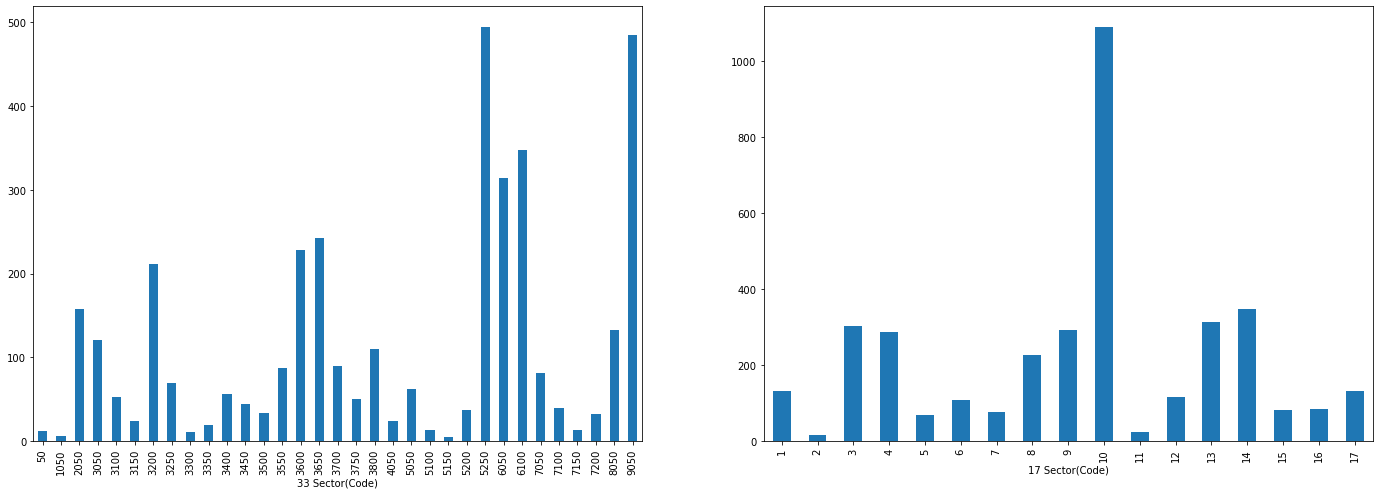

In [5]:
display_markdown('#### 業種別企業数の分布', raw=True)
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
sector_table.groupby('33 Sector(Code)').count()['stock_code'].plot.bar()

plt.subplot(1, 2, 2)
sector_table.groupby('17 Sector(Code)').count()['stock_code'].plot.bar()

In [6]:
for i in range(1, 18):
    print(f'sector {i}:', end='')
    print(stock_list[stock_list['17 Sector(Code)'] == i]['17 Sector(name)'].values[0])

sector 1:FOODS 
sector 2:ENERGY RESOURCES 
sector 3:CONSTRUCTION & MATERIALS 
sector 4:RAW MATERIALS & CHEMICALS 
sector 5:PHARMACEUTICAL 
sector 6:AUTOMOBILES & TRANSPORTATION EQUIPMENT 
sector 7:STEEL & NONFERROUS METALS 
sector 8:MACHINERY 
sector 9:ELECTRIC APPLIANCES & PRECISION INSTRUMENTS 
sector 10:IT & SERVICES, OTHERS 
sector 11:ELECTRIC POWER & GAS 
sector 12:TRANSPORTATION & LOGISTICS 
sector 13:COMMERCIAL & WHOLESALE TRADE 
sector 14:RETAIL TRADE 
sector 15:BANKS 
sector 16:FINANCIALS （EX BANKS） 
sector 17:REAL ESTATE 


In [7]:
# ニュースと業種を紐づける
articles = pd.merge(articles, stock_list[['stock_code', '33 Sector(Code)', '17 Sector(Code)']], on='stock_code')
display(articles.head(3))

article_id          publish_datetime media_code  \
0  TDSKDBDGXMZO5400542031122019NN1000 2020-01-01 00:00:33+09:00        TNY   
1  TDSKDBDGXKZO5400896001012020MM8000 2020-01-01 01:43:50+09:00        TNY   
2  TDSKDBDGXMZO5400971001012020CZ8000 2020-01-01 12:01:51+09:00        TNY   

  media_name  men_name  page_from picture_flag  paragraph_cnt  char_length  \
0  日本経済新聞電子版       NaN        NaN            有             19         1778   
1  日本経済新聞電子版       NaN        NaN          NaN              4          569   
2  日本経済新聞電子版       NaN        NaN          NaN             10          928   

                                            headline  \
0                           ゴーン元会長、周到な不意打ち出国　司法批判の声明   
1  元日付のこういうコラムは、ふつうなら来し方行く末に思いをはせ、まずは新年をことほぐものである...   
2                          ゴーン元会長、出国準備に数週間　米報道「共犯者も」   

                                            keywords  \
0  カルロス・ゴーン\n日産自動車\nグレッグ・ケリー\n弘中惇一郎\nＭｕｓｉｃＴｅｌｅｖｉｓ...   
1              春秋\nカルロス・ゴーン\nコラム\n来し方行く末\n思い\n日付\n新年   
2  カルロス・ゴーン\nウォールストリートジャーナル\n日産自動車\n共犯者\nレバノン\n元会...   

                                     classifications stock_code  \
0  ＄絵写表記事\nＴ７２０１\nＰＤ２７１\nＮ０００１３５１\nＮ００４４３７１\n＃Ｗ５０...       7201   
1  「春秋」\n＊春秋\nＴ７２０１\nＰＤ２７１\nＮ０００１３５１\n＃Ｗ５０３０５\n＃Ｗ...       7201   
2  Ｔ７２０１\nＰＤ２７１\nＮ０００１３５１\n＃Ｗ５０３０１\n＃Ｗ５０３０５\n＃Ａ７４...       7201   

   33 Sector(Code)  17 Sector(Code)  
0             3700                6  
1             3700                6  
2             3700                6

#### 業種別のニュース発行数

<AxesSubplot:xlabel='17 Sector(Code)'>

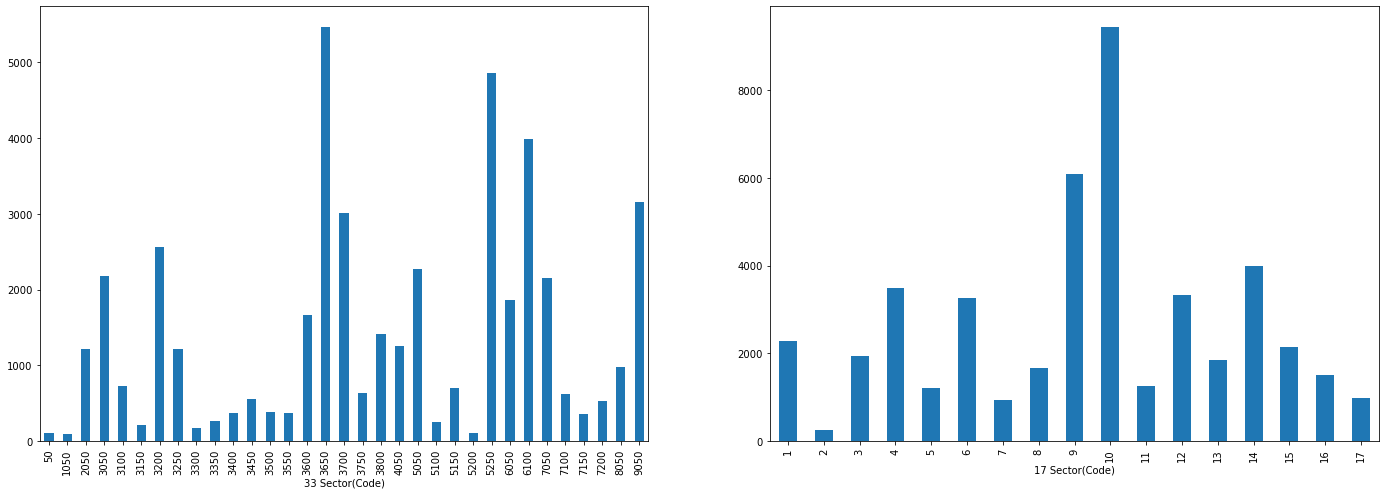

In [8]:
display_markdown('#### 業種別のニュース発行数', raw=True)
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
articles.groupby('33 Sector(Code)').count()['stock_code'].plot.bar()

plt.subplot(1, 2, 2)
articles.groupby('17 Sector(Code)').count()['stock_code'].plot.bar()

### セクターごとでイベントスタディ分析をしてみる

In [9]:
prices = pd.read_csv('../data/stock_price.csv.gz')
prices.rename(columns={'EndOfDayQuote Date':'Date'}, inplace=True)
prices.set_index('Date', inplace=True)
prices.index = pd.to_datetime(prices.index)
prices.head()

Local Code  EndOfDayQuote Open  EndOfDayQuote High  \
Date                                                             
2016-01-04        1301              2800.0              2820.0   
2016-01-05        1301              2750.0              2780.0   
2016-01-06        1301              2760.0              2770.0   
2016-01-07        1301              2740.0              2760.0   
2016-01-08        1301              2700.0              2740.0   

            EndOfDayQuote Low  EndOfDayQuote Close  \
Date                                                 
2016-01-04             2740.0               2750.0   
2016-01-05             2750.0               2760.0   
2016-01-06             2740.0               2760.0   
2016-01-07             2710.0               2710.0   
2016-01-08             2690.0               2700.0   

            EndOfDayQuote ExchangeOfficialClose  EndOfDayQuote Volume  \
Date                                                                    
2016-01-04                               2750.0               32000.0   
2016-01-05                               2760.0               20100.0   
2016-01-06                               2760.0               15000.0   
2016-01-07                               2710.0               31400.0   
2016-01-08                               2700.0               26200.0   

            EndOfDayQuote CumulativeAdjustmentFactor  \
Date                                                   
2016-01-04                                       0.1   
2016-01-05                                       0.1   
2016-01-06                                       0.1   
2016-01-07                                       0.1   
2016-01-08                                       0.1   

            EndOfDayQuote PreviousClose EndOfDayQuote PreviousCloseDate  \
Date                                                                      
2016-01-04                       2770.0                      2015/12/30   
2016-01-05                       2750.0                      2016/01/04   
2016-01-06                       2760.0                      2016/01/05   
2016-01-07                       2760.0                      2016/01/06   
2016-01-08                       2710.0                      2016/01/07   

            EndOfDayQuote PreviousExchangeOfficialClose  \
Date                                                      
2016-01-04                                       2770.0   
2016-01-05                                       2750.0   
2016-01-06                                       2760.0   
2016-01-07                                       2760.0   
2016-01-08                                       2710.0   

           EndOfDayQuote PreviousExchangeOfficialCloseDate  \
Date                                                         
2016-01-04                                      2015/12/30   
2016-01-05                                      2016/01/04   
2016-01-06                                      2016/01/05   
2016-01-07                                      2016/01/06   
2016-01-08                                      2016/01/07   

            EndOfDayQuote ChangeFromPreviousClose  \
Date                                                
2016-01-04                                  -20.0   
2016-01-05                                   10.0   
2016-01-06                                    0.0   
2016-01-07                                  -50.0   
2016-01-08                                  -10.0   

            EndOfDayQuote PercentChangeFromPreviousClose  EndOfDayQuote VWAP  
Date                                                                          
2016-01-04                                        -0.722            2778.250  
2016-01-05                                         0.364            2761.990  
2016-01-06                                         0.000            2758.867  
2016-01-07                                        -1.812            2733.471  
2016-01-08                                  

In [10]:
import pandas_datareader.data as pdr

TOPIX = pdr.DataReader('1305.T', 'yahoo', '2008/01/01') # Daiwa Topix Listed
TOPIX.rename(columns={'Adj Close':'TOPIX'}, inplace=True)
display(TOPIX.head())

RF_rate = pdr.DataReader('IRSTCI01JPM156N', 'fred', '2008/01/01') / 100 # Immediate Rates: Less than 24 Hours: Call Money/Interbank Rate for Japan
# 月次データになっているため日次に変換する
RF_rate = RF_rate.resample('D').fillna(method='ffill')
RF_rate.reset_index(inplace=True)
RF_rate.columns = ['Date', 'R_f']
RF_rate.set_index('Date', inplace=True)
display(RF_rate.head())

High          Low         Open        Close  Volume  \
Date                                                                     
2008-01-07  1420.400024  1420.400024  1420.400024  1420.400024     0.0   
2008-01-08  1431.199951  1431.199951  1431.199951  1431.199951     0.0   
2008-01-09  1452.699951  1452.699951  1452.699951  1452.699951     0.0   
2008-01-10  1429.300049  1429.300049  1429.300049  1429.300049     0.0   
2008-01-11  1405.300049  1405.300049  1405.300049  1405.300049     0.0   

                  TOPIX  
Date                     
2008-01-07  1420.400024  
2008-01-08  1431.199951  
2008-01-09  1452.699951  
2008-01-10  1429.300049  
2008-01-11  1405.300049

R_f
Date               
2008-01-01  0.00502
2008-01-02  0.00502
2008-01-03  0.00502
2008-01-04  0.00502
2008-01-05  0.00502

In [11]:
from sklearn import linear_model

def ivent_study(targets, prices, TOPIX, RF_rate, window=130):
    '''
    args:
        targets;対象銘柄
        prices :株価情報
        window :推定ウィンドウサイズ(営業日), 祝日などがあるため、実際はこれより小さくなる
    
    '''
    R2s, ARs, Post_ARs, CARs = [], [], [], [] # 推定時の決定係数, 異常リターン, ポスト異常リターン, 累積異常リターン

    for i in targets.index:
        # 対象銘柄の価格情報
        df_price_one_code = prices[prices['Local Code'] == int(targets['stock_code'][i])]
        
        # 推定に必要なデータをマージする
        df_price_one_code = pd.merge(df_price_one_code, TOPIX['TOPIX'], left_index=True, right_index=True)
        df_price_one_code = pd.merge(df_price_one_code, RF_rate, left_index=True, right_index=True)

        # 推定に必要なデータを計算
        df_price_one_code['R_i'] = np.log(df_price_one_code['EndOfDayQuote ExchangeOfficialClose']).diff()
        df_price_one_code['R_M'] = np.log(df_price_one_code['TOPIX']).diff()
        df_price_one_code['R_M-R_f'] = df_price_one_code['R_M'] - df_price_one_code['R_f']
        df_price_one_code.dropna(subset=['R_f', 'R_i', 'R_M', 'R_M-R_f'], inplace=True)

        # 時点の設定
        event_date = pd.to_datetime(targets['publish_datetime'][i].date()) 
        t_0 = event_date - pd.offsets.BDay(n=window + 2) # 推定ウィンドウの開始時点
        t_1 = event_date - pd.offsets.BDay(n=2)          # 推定ウィンドウ時点
        t_2 = event_date - pd.offsets.BDay(n=1)          # イベントウィンドウの開始時点
        t_3 = event_date + pd.offsets.BDay(n=1)          # イベントウィンドウの終了時点
        t_4 = event_date + pd.offsets.BDay(n=2)          # ポストウィンドウの開始時点
        t_5 = event_date + pd.offsets.BDay(n=22)         # ポストウィンドウの終了時点

        # 推定できるデータ量があるかチェック
        if t_0 < df_price_one_code.index[0]  or df_price_one_code.index[-1] < t_3 :
            # インデックスサイズがオーバーのため、スキップ
            continue 

        # 推定(イベント日-132 ～ イベント日-2)
        estimate_window = df_price_one_code[(df_price_one_code.index >= t_0) & (df_price_one_code.index <= t_1)]

        # 説明変数
        X = estimate_window['R_M-R_f'].values[1:].reshape(-1, 1) # nanを除く

        # 目的変数
        Y = estimate_window['R_i'].values[1:].reshape(-1, 1) # nanを除く

        # 予測モデルを作成
        clf = linear_model.LinearRegression()
        clf.fit(X, Y)

        # イベントウィンドウ
        event_window = df_price_one_code[(df_price_one_code.index >= t_2) & (df_price_one_code.index <= t_3)]
        post_window = df_price_one_code[(df_price_one_code.index >= t_4) & (df_price_one_code.index <= t_5)]

        # 株価が取得できない場合はスキップ
        if len(event_window) < 3 or len(post_window) < 20:
            continue

        # アブノーマルリターン, 累積アブノーマルリターンを推定
        AR = event_window['R_i'].values - (clf.intercept_ + clf.coef_ * event_window['R_M-R_f'].values)
        Post_AR = post_window['R_i'].values - (clf.intercept_ + clf.coef_ * post_window['R_M-R_f'].values)
        CAR = np.sum(AR)

        # 結果を格納
        R2s.append(clf.score(X, Y))
        ARs.append(AR)
        CARs.append(CAR)
        Post_ARs.append(Post_AR)
        
    results = pd.concat([pd.DataFrame(pd.Series(R2s), columns=['R2']), 
                         pd.DataFrame(np.array(ARs)[:, 0], columns=['AR_0', 'AR_1', 'AR_2']),
                         pd.DataFrame(pd.Series(CARs), columns=['CAR']),
                         pd.DataFrame([v.reshape(-1) for v in  Post_ARs], 
                                      columns=[f'AR_{i+3}' for i in range(21)]).dropna(axis=1).reset_index(drop=True),
                        ], axis=1) # なぜか列数が21となるため、drop()で対応
    
    return results

In [21]:
results = {}
for i in range(1, 18):
    
    # 1セクターだけにする
    targets = articles[articles['17 Sector(Code)'] == i].copy()
    
    # セクターごとのイベントスタディ分析
    results[f'sector_{i}'] = ivent_study(targets, prices, TOPIX, RF_rate)
    

In [22]:
from scipy import stats

t_results = {}
sample_num = []
for i in range(1, 18):
    sector_name = stock_list[stock_list['17 Sector(Code)'] == i]['17 Sector(name)'].values[0]
    t_results[(f'sector{i}', sector_name)] = stats.ttest_1samp(results[f'sector_{i}']['CAR'] / results[f'sector_{i}']['CAR'].std(), 0)
    sample_num.append(len(results[f'sector_{i}']))
    
df_t_result = pd.DataFrame(t_results).T
df_t_result.columns = ['t', 'p-value']
df_t_result['samples'] = sample_num
display(df_t_result)

t       p-value  \
sector1  FOODS                                         1.027655  3.043293e-01   
sector2  ENERGY RESOURCES                             -3.192601  1.720294e-03   
sector3  CONSTRUCTION & MATERIALS                      1.784952  7.455909e-02   
sector4  RAW MATERIALS & CHEMICALS                     3.461495  5.499150e-04   
sector5  PHARMACEUTICAL                                2.277410  2.308524e-02   
sector6  AUTOMOBILES & TRANSPORTATION EQUIPMENT       -1.173027  2.409673e-01   
sector7  STEEL & NONFERROUS METALS                     2.994656  2.886247e-03   
sector8  MACHINERY                                     0.181961  8.556570e-01   
sector9  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS  -0.379078  7.046571e-01   
sector10 IT & SERVICES, OTHERS                         1.516659  1.294251e-01   
sector11 ELECTRIC POWER & GAS                         -3.392699  7.391683e-04   
sector12 TRANSPORTATION & LOGISTICS                   -2.285362  2.242262e-02   
sector13 COMMERCIAL & WHOLESALE TRADE                 -0.740730  4.590376e-01   
sector14 RETAIL TRADE                                 -0.278691  7.805124e-01   
sector15 BANKS                                        -6.094757  1.513684e-09   
sector16 FINANCIALS （EX BANKS）                        -1.460160  1.446786e-01   
sector17 REAL ESTATE                                  -1.701019  8.967264e-02   

                                                       samples  
sector1  FOODS                                            1146  
sector2  ENERGY RESOURCES                                  150  
sector3  CONSTRUCTION & MATERIALS                         1046  
sector4  RAW MATERIALS & CHEMICALS                        1775  
sector5  PHARMACEUTICAL                                    652  
sector6  AUTOMOBILES & TRANSPORTATION EQUIPMENT           1534  
sector7  STEEL & NONFERROUS METALS                         492  
sector8  MACHINERY                                         838  
sector9  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS      2997  
sector10 IT & SERVICES, OTHERS                            4376  
sector11 ELECTRIC POWER & GAS                              582  
sector12 TRANSPORTATION & LOGISTICS                       1592  
sector13 COMMERCIAL & WHOLESALE TRADE                      965  
sector14 RETAIL TRADE                                     1910  
sector15 BANKS                                            1102  
sector16 FINANCIALS （EX BANKS）                             727  
sector17 REAL ESTATE                                       425

In [23]:
# 有意水準5％以下だけにする
display(df_t_result[df_t_result['p-value'] < 0.05])

t       p-value  samples
sector2  ENERGY RESOURCES            -3.192601  1.720294e-03      150
sector4  RAW MATERIALS & CHEMICALS    3.461495  5.499150e-04     1775
sector5  PHARMACEUTICAL               2.277410  2.308524e-02      652
sector7  STEEL & NONFERROUS METALS    2.994656  2.886247e-03      492
sector11 ELECTRIC POWER & GAS        -3.392699  7.391683e-04      582
sector12 TRANSPORTATION & LOGISTICS  -2.285362  2.242262e-02     1592
sector15 BANKS                       -6.094757  1.513684e-09     1102

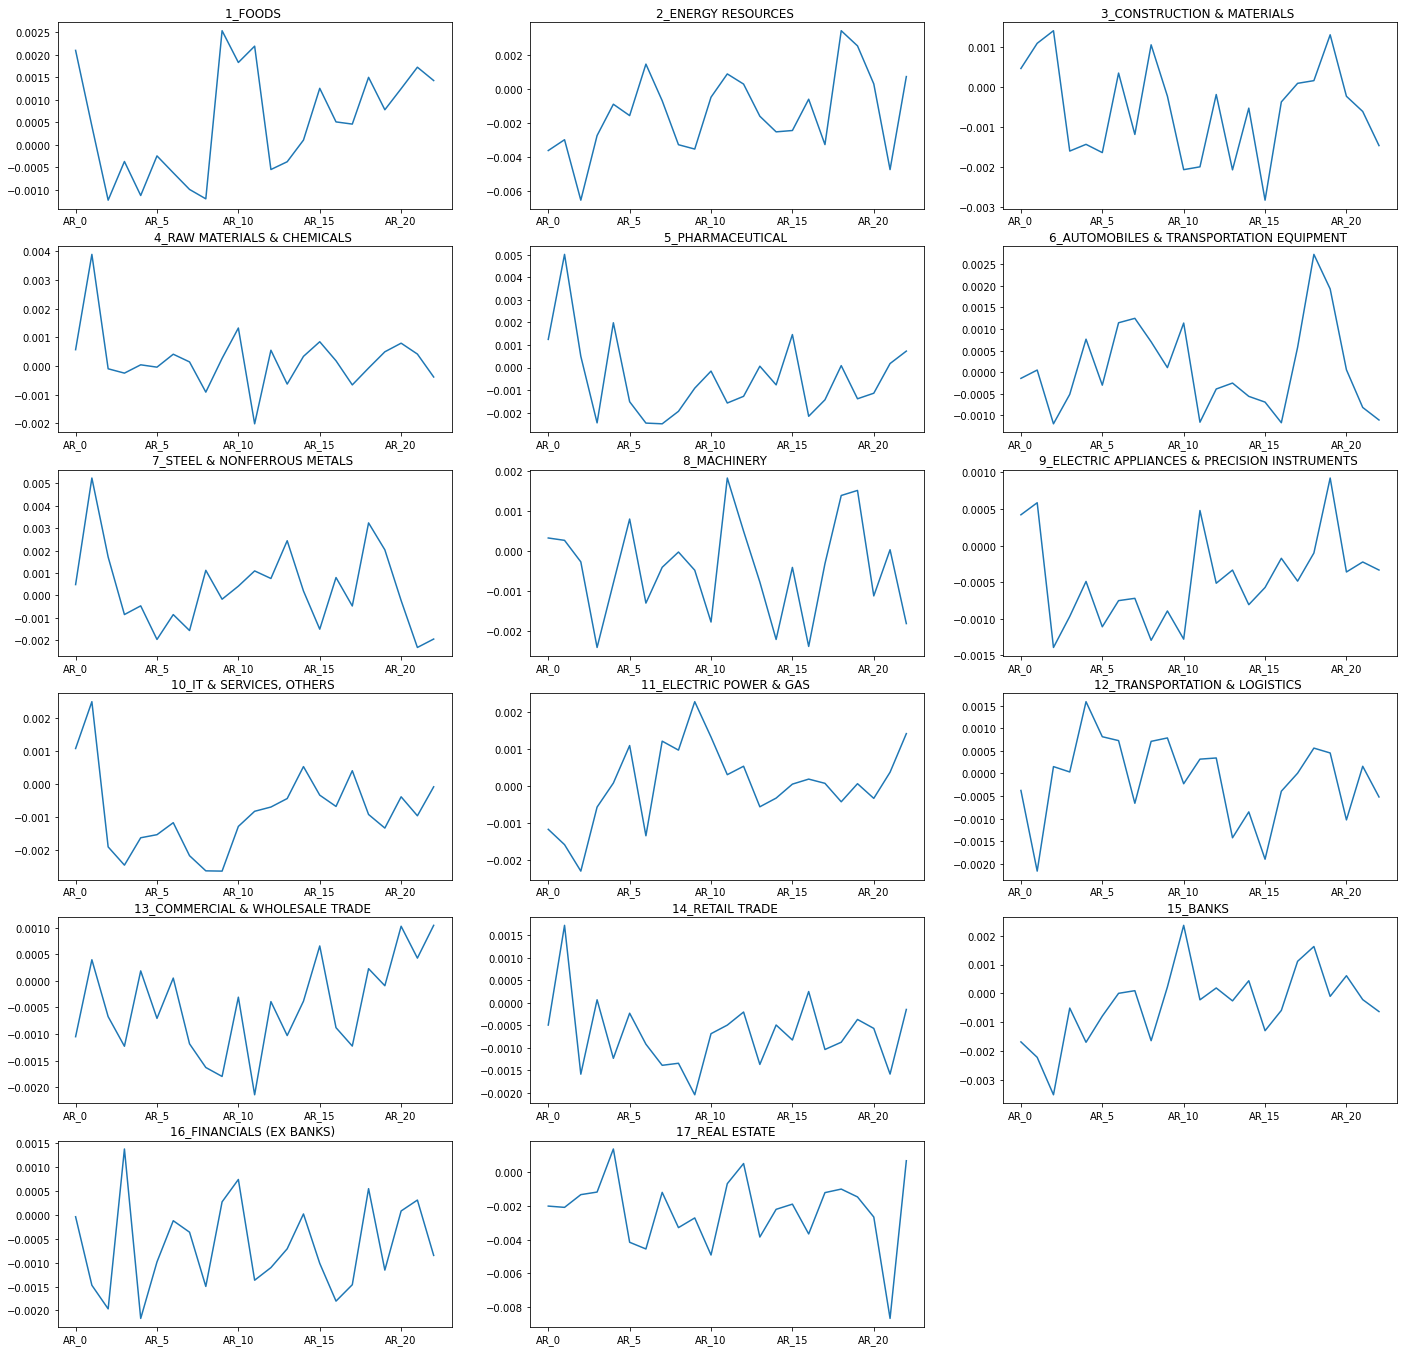

In [24]:
AR_col = results['sector_1'].columns[results['sector_1'].columns.str.contains('AR_')]

plt.figure(figsize=(24, 24))
for i in range(1, 18):
    sector_name = stock_list[stock_list['17 Sector(Code)'] == i]['17 Sector(name)'].values[0]
    sector_name = sector_name.translate(str.maketrans({'（':'(', '）':')'})) # 置換しないとWarningが出る
    plt.subplot(6, 3, i)
    results[f'sector_{i}'][AR_col].mean().plot()
    plt.title(f'{i}_{sector_name}')

* セクター間でニュースがリターンに影響を与える差はありそう
* 20日も経過するとリターンはゼロに回帰していることがほとんどのように見える
* BANK(金融業)はニュースリリース後に負のリターンとなる可能性が他の業界に比べて高い

## 検証②
* ニュース記事をクラスタリングしてみた時に各クラスターでリターンに差があるのか。

In [12]:
df_article = pd.read_csv('../data/nikkei_article.csv.gz')
stock_list = pd.read_csv('../data/stock_list.csv.gz')
codes = stock_list['Local Code'].astype(str)
df_price = pd.read_csv('../data/stock_price.csv.gz', index_col='EndOfDayQuote Date', parse_dates=['EndOfDayQuote Date'])
headline_features = pd.read_pickle('../data/headline_features.pkl') # 文章の特徴量を読込み
headline_features.columns = [f'feature_{i}' for i in headline_features.columns]

# 文章の特徴量と元データをリンクさせる
df_article.dropna(subset=['headline', 'keywords'], inplace=True)

# headlineもしくは、keywordsどちらかで人事を含むニュース記事のindexマスクを作成。
drop_mask = df_article['headline'].str.contains('人事') | df_article['keywords'].str.contains('人事')

# '人事'を含む行を除外する
df_article = df_article[~drop_mask].copy()

# 結合する
df_article = pd.concat([df_article.reset_index(drop=True), headline_features.reset_index(drop=True)], axis=1).copy()

# company_g.stock_codeが存在するもののみを対象とする
df_target = df_article[df_article['company_g.stock_code'].isin(codes)].copy()

display(df_target.head())

article_id           publish_datetime media_code  \
7   TDSKDBDGXMZO5400542031122019NN1000  2020-01-01T00:00:33+09:00        TNY   
16  TDSKDBDGXMZO5387164027122019L41000  2020-01-01T01:00:00+09:00        TNY   
19  TDSKDBDGXKZO5400896001012020MM8000  2020-01-01T01:43:50+09:00        TNY   
23  TDSKDBDGXMZO5345668017122019000000  2020-01-01T02:00:00+09:00        TNY   
27  TDSKDBDGXMZO5368986023122019L60000  2020-01-01T02:00:00+09:00        TNY   

   media_name  men_name  page_from picture_flag  paragraph_cnt  char_length  \
7   日本経済新聞電子版       NaN        NaN            有             19         1778   
16  日本経済新聞電子版       NaN        NaN            有             12         1347   
19  日本経済新聞電子版       NaN        NaN          NaN              4          569   
23  日本経済新聞電子版       NaN        NaN            有             29         3109   
27  日本経済新聞電子版       NaN        NaN            有             17         1429   

                                             headline  ... feature_758  \
7                            ゴーン元会長、周到な不意打ち出国　司法批判の声明  ...   -0.016836   
16                              地銀が変わる、始まったマニュアルなき大競争  ...   -0.273573   
19  元日付のこういうコラムは、ふつうなら来し方行く末に思いをはせ、まずは新年をことほぐものである...  ...   -0.227540   
23           Googleの最新AI、読解力も人間超え　驚異の学習法\n超人間・万能AI（上）  ...   -0.288732   
27             日光、国際リゾート地に　リッツ・カールトン5月開業\n注目施設2020(1)  ...   -0.167446   

   feature_759 feature_760  feature_761  feature_762  feature_763  \
7     0.098866    0.286864     0.203411     0.453875     0.399321   
16    0.475515    0.421222    -0.019972     0.397417    -0.016916   
19    0.219154    0.269517    -0.458477     0.522750    -0.488461   
23    0.675902    0.263377    -0.352912    -0.105781    -0.303692   
27    0.564255   -0.001849     0.147790     0.465038     0.038460   

    feature_764  feature_765  feature_766  feature_767  
7      0.591646    -0.245139    -0.410970    -0.369061  
16    -0.097602    -0.441624    -0.104872    -0.636333  
19     0.549632    -0.223382    -0.032229    -0.267484  
23     0.112427    -0.660242    -0.337175    -0.080914  
27     0.403165    -0.501207     0.054829     0.176805  

[5 rows x 781 columns]

In [13]:
# 日付修正処理
import datetime
def convert_datetime(t):
    '''
    時刻が15時より後の場合は翌営業日の15:00に変換。それ以外は、時刻部分を15:00に変換。
    '''
    t_ret = t.replace(hour=15, minute=0, second=0)
    
    if t.time() > datetime.time(15, 0, 0):
        t_ret = t_ret + pd.offsets.BDay(1)
    
    return t_ret

df_target['publish_datetime'] = pd.to_datetime(df_target['publish_datetime'])
df_target['publish_datetime'] = df_target['publish_datetime'].apply(convert_datetime)

returns = {'1days':[], '5days':[], '20days':[]}
for i in df_target.index:
    # 対象銘柄の価格情報
    df_price_one_code = df_price[df_price['Local Code'] == int(df_target['company_g.stock_code'][i])]

    # ニュース公表日以降を取り出し
    mask = df_price_one_code.index >= pd.to_datetime(df_target['publish_datetime'][i].date())
    df_price_one_code = df_price_one_code[mask]

    # 各リターンを格納する
    for key, num in zip(returns.keys(), [1, 5, 20]):
        try:
            returns[key].append(df_price_one_code['EndOfDayQuote ExchangeOfficialClose'].pct_change(num).dropna()[0])
        except:
            returns[key].append(np.nan)

df_target['1days_R'] = returns['1days']
df_target['5days_R'] = returns['5days']
df_target['20days_R'] = returns['20days']

display(df_target.head(3))

article_id          publish_datetime media_code  \
7   TDSKDBDGXMZO5400542031122019NN1000 2020-01-01 15:00:00+09:00        TNY   
16  TDSKDBDGXMZO5387164027122019L41000 2020-01-01 15:00:00+09:00        TNY   
19  TDSKDBDGXKZO5400896001012020MM8000 2020-01-01 15:00:00+09:00        TNY   

   media_name  men_name  page_from picture_flag  paragraph_cnt  char_length  \
7   日本経済新聞電子版       NaN        NaN            有             19         1778   
16  日本経済新聞電子版       NaN        NaN            有             12         1347   
19  日本経済新聞電子版       NaN        NaN          NaN              4          569   

                                             headline  ... feature_761  \
7                            ゴーン元会長、周到な不意打ち出国　司法批判の声明  ...    0.203411   
16                              地銀が変わる、始まったマニュアルなき大競争  ...   -0.019972   
19  元日付のこういうコラムは、ふつうなら来し方行く末に思いをはせ、まずは新年をことほぐものである...  ...   -0.458477   

   feature_762 feature_763  feature_764  feature_765  feature_766  \
7     0.453875    0.399321     0.591646    -0.245139    -0.410970   
16    0.397417   -0.016916    -0.097602    -0.441624    -0.104872   
19    0.522750   -0.488461     0.549632    -0.223382    -0.032229   

    feature_767   1days_R   5days_R  20days_R  
7     -0.369061  0.017586 -0.011990 -0.060592  
16    -0.636333  0.008439 -0.046414 -0.067511  
19    -0.267484  0.017586 -0.011990 -0.060592  

[3 rows x 784 columns]

In [14]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(random_state=0) # Default:8 cluster

In [15]:
kmeans_model.fit(df_target.loc[:, df_target.columns.str.contains('feature_')])

KMeans(random_state=0)

In [16]:
df_target['labels'] = kmeans_model.labels_
display(df_target.head(3))

article_id          publish_datetime media_code  \
7   TDSKDBDGXMZO5400542031122019NN1000 2020-01-01 15:00:00+09:00        TNY   
16  TDSKDBDGXMZO5387164027122019L41000 2020-01-01 15:00:00+09:00        TNY   
19  TDSKDBDGXKZO5400896001012020MM8000 2020-01-01 15:00:00+09:00        TNY   

   media_name  men_name  page_from picture_flag  paragraph_cnt  char_length  \
7   日本経済新聞電子版       NaN        NaN            有             19         1778   
16  日本経済新聞電子版       NaN        NaN            有             12         1347   
19  日本経済新聞電子版       NaN        NaN          NaN              4          569   

                                             headline  ... feature_762  \
7                            ゴーン元会長、周到な不意打ち出国　司法批判の声明  ...    0.453875   
16                              地銀が変わる、始まったマニュアルなき大競争  ...    0.397417   
19  元日付のこういうコラムは、ふつうなら来し方行く末に思いをはせ、まずは新年をことほぐものである...  ...    0.522750   

   feature_763 feature_764  feature_765  feature_766  feature_767   1days_R  \
7     0.399321    0.591646    -0.245139    -0.410970    -0.369061  0.017586   
16   -0.016916   -0.097602    -0.441624    -0.104872    -0.636333  0.008439   
19   -0.488461    0.549632    -0.223382    -0.032229    -0.267484  0.017586   

     5days_R  20days_R  labels  
7  -0.011990 -0.060592       2  
16 -0.046414 -0.067511       2  
19 -0.011990 -0.060592       2  

[3 rows x 785 columns]

In [17]:
df_target = df_target.replace([np.inf, -np.inf], np.nan).copy()
df_target_cluster = df_target[['1days_R', '5days_R', '20days_R', 'labels']]
display_markdown('### Return maean', raw=True)
display(df_target_cluster.groupby('labels').mean())
display_markdown('### Smple num', raw=True)
display(df_target_cluster.groupby('labels').count())

### Return maean

1days_R   5days_R  20days_R
labels                              
0       0.000342  0.006072  0.007136
1       0.000774  0.003043  0.003461
2       0.001919  0.002478  0.002637
3       0.000094 -0.002648 -0.006483
4      -0.002166 -0.007626 -0.010259
5       0.000605 -0.000171  0.000316
6      -0.000701 -0.002940 -0.010082
7       0.004378  0.008336  0.010476

### Smple num

1days_R  5days_R  20days_R
labels                            
0          4231     4212      4151
1          5378     5306      4925
2          5156     5074      4793
3           681      679       634
4          3204     3188      3059
5          8787     8658      8178
6          3530     3502      3320
7          5805     5771      5569

In [19]:
from scipy import stats
# 検定:各クラスターの平均μ=0
t_p = {}
for i in range(8):
    df_one_cluster = df_target_cluster[df_target_cluster['labels'] == i]
    for n in [1, 5, 20]:
        R_n = df_one_cluster[f'{n}days_R'].dropna()
        t_p[(i, f'{n}days_R')] = stats.ttest_1samp(R_n / R_n.std(), 0)

In [20]:
df_tp = pd.DataFrame(t_p)
df_tp.index = ['t', 'p']
df_tp = df_tp.T.unstack()
df_tp

t                             p                            
    1days_R  20days_R   5days_R   1days_R      20days_R       5days_R
0  0.649715  3.045445  6.040595  0.515911  2.337949e-03  1.668113e-09
1  1.801406  1.772070  2.938351  0.071695  7.644478e-02  3.313843e-03
2  2.722528  1.265953  1.678088  0.006500  2.055914e-01  9.339151e-02
3  0.081787 -1.235499 -1.128615  0.934840  2.171033e-01  2.594597e-01
4 -3.598524 -3.757883 -5.820756  0.000325  1.745577e-04  6.439695e-09
5  1.757076  0.210014 -0.219854  0.078940  8.336622e-01  8.259898e-01
6 -1.731662 -4.952167 -2.989841  0.083421  7.705463e-07  2.810652e-03
7  4.621912  4.007748  4.236291  0.000004  6.210097e-05  2.307797e-05

In [21]:
df_target_cluster_mean = df_target_cluster.groupby('labels').mean()
display(df_target_cluster_mean)
display(df_target_cluster_mean[df_tp['p']<0.05])

1days_R   5days_R  20days_R
labels                              
0       0.000342  0.006072  0.007136
1       0.000774  0.003043  0.003461
2       0.001919  0.002478  0.002637
3       0.000094 -0.002648 -0.006483
4      -0.002166 -0.007626 -0.010259
5       0.000605 -0.000171  0.000316
6      -0.000701 -0.002940 -0.010082
7       0.004378  0.008336  0.010476

1days_R   5days_R  20days_R
labels                              
0            NaN  0.006072  0.007136
1            NaN  0.003043       NaN
2       0.001919       NaN       NaN
3            NaN       NaN       NaN
4      -0.002166 -0.007626 -0.010259
5            NaN       NaN       NaN
6            NaN -0.002940 -0.010082
7       0.004378  0.008336  0.010476

クラスター4とクラスター7では、3期間を通して有意であることがわかる。   
この2つについてもう少し見てみる必要がありそう。  
* 各クラスターにおける文章の特徴(単語の頻度とか?⇒wordcloud, scatter text) ←チュートリアルを参考

## PCA(主成分分析)
主成分分析による次元圧縮⇒K-meansの流れでもよかったかもしれない。(結果はかわらないのかもだが)

In [34]:
from sklearn.decomposition import PCA

In [35]:
#主成分分析の実行
pca = PCA()
pca.fit(df_target.loc[:, df_target.columns.str.contains('feature_')])

# データを主成分空間に写像 = 次元圧縮
pca_feature = pca.transform(df_target.loc[:, df_target.columns.str.contains('feature_')])

<AxesSubplot:>

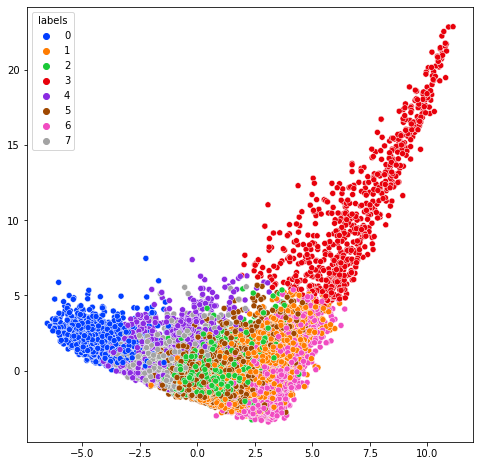

In [36]:
import seaborn as sns

# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(8, 8))
sns.scatterplot(x=pca_feature[:, 0], y=pca_feature[:, 1], hue=df_target_cluster['labels'], palette='bright')

クラスタリングの分類のされ方について上記の図からおおよそ理解できる。  
クラスター4とクラスター7は上図では非常に近くに分布していることがわかる。

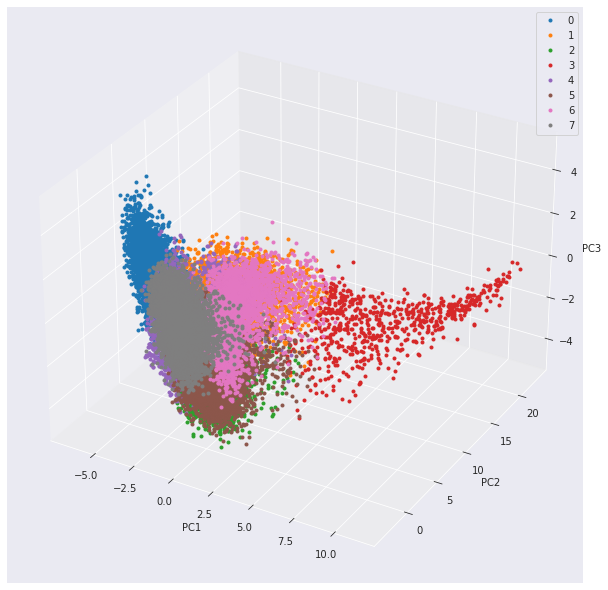

In [37]:
sns.set_style("darkgrid")

#3次元プロットするためのモジュール
from mpl_toolkits.mplot3d import Axes3D

#グラフの枠を作っていく
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
# ax.view_init(30, 30) # 角度を変えたる時はこれを調整

#軸にラベルを付けたいときは書く
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

#.plotで描画
#linestyle='None'にしないと初期値では線が引かれるが、3次元の散布図だと大抵ジャマになる
for n in range(8):
    X = pca_feature[np.where(list(df_target_cluster.reset_index()['labels'] == n))[0].tolist(), 0]
    Y = pca_feature[np.where(list(df_target_cluster.reset_index()['labels'] == n))[0].tolist(), 1]
    Z = pca_feature[np.where(list(df_target_cluster.reset_index()['labels'] == n))[0].tolist(), 2]
    
    ax.plot(X, Y, Z, marker='o', markersize=3, linestyle='None', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][n], label=n)

#最後に.show()を書いてグラフ表示
plt.legend()
plt.show()

### wordcloudを利用してみる

In [38]:
import MeCab, gc, string

articles = pd.read_csv('../data/nikkei_article.csv.gz')

owakati = MeCab.Tagger(f"-Owakati -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")
ochasen = MeCab.Tagger(f"-Ochasen -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")

def parse_by_ochasen(tagger, text):
    # Ochasenでmecab-ipadic-neologdの辞書を使ったときの、返り値のデータ順は以下となる。
    columns = ['表層形', '発音', '原型', '形態素の品詞型', '活用形', '活用型']

    # Ochasenよりコーパスタグ付けを行う。
    parsed = [item.split('\t') for item in tagger.parse(str(text)).split("\n") if item not in ('EOS', '')]
    return pd.DataFrame(parsed, columns=columns)


def build_stopwords(parsed_by_ochasen, non_skip_flags=["数"], skip_flags = ["名詞", "動詞", "形容詞", "副詞"]):
    gc.collect()
    stopwords = set()

    for parsed in tqdm(parsed_by_ochasen):
        # non_skip_flagsが入っているものは全てstopwordsとして扱う
        # それ以外において、skip_flagsをひとつでも含んでいないものをstopwordsとして扱う
        mask_include_non_skip_flags = parsed['形態素の品詞型'].apply(lambda x: any([non_skip_flag in x.split('-') for non_skip_flag in non_skip_flags]))
        mask_exclude_skip_flags = parsed['形態素の品詞型'].apply(lambda x: not any([skip_flag in x.split('-') for skip_flag in skip_flags]))

        #日、月、年度のようなユニット情報を含むものは全てstopwordsとして扱う
        mask_include_unit_info = parsed['表層形'].apply(lambda x: False if re.fullmatch(r'\d+(秒|分|時|日|月|カ月|年|人|ドル|円)', x) is None else True)

        stopword_candidate = parsed['表層形'][mask_include_non_skip_flags | mask_exclude_skip_flags | mask_include_unit_info]

        # stopwordsセットにアップデートする。
        stopwords = stopwords | set(stopword_candidate.tolist())

    # 追加的に単一アルファベットをstopwordsとして追加する
    stopwords = stopwords | set(string.ascii_lowercase) | set(string.ascii_uppercase)

    # 追加的に単一数字をstopwordsとして追加する
    stopwords = stopwords | set([str(idx) for idx in range(10)])

    return stopwords

parsed_headline_by_ochasen = df_target['headline'].apply(lambda x: parse_by_ochasen(tagger=ochasen, text=x)[['表層形', '形態素の品詞型']])
parsed_keywords_by_ochasen = articles['keywords'].apply(lambda x: parse_by_ochasen(tagger=ochasen, text=x)[['表層形', '形態素の品詞型']])

# headline, keywords各々のコーパスからsubwordsを取得する。
headline_stopwords = build_stopwords(parsed_by_ochasen=parsed_headline_by_ochasen)
keywords_stopwords = build_stopwords(parsed_by_ochasen=parsed_keywords_by_ochasen)

In [39]:
from wordcloud import WordCloud

def display_wordcloud(tagger, texts, stopwords, collocations):
    # textsがpd.Seriesでない時に、pd.Seriesに変換
    if isinstance(texts, pd.Series) is False:
        texts = pd.Series(texts)

    # テキストは単語別にスペースで区切りされ、テキストごとはスペースでつながっていることが期待値
    words_with_space = texts.apply(lambda x: tagger.parse(x).strip("\n").rstrip())
    words_with_space = ' '.join(words_with_space)

    # wordcloudを表示するため、パラメータを渡しインスタンス化する。
    # collocations=Falseの場合、連語による重複単語が表示されない。
    wordcloud = WordCloud(
        background_color="white",
        font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
        stopwords=stopwords,
        width=2000,
        height=1000,
        collocations=collocations,
        random_state=0,
    ).generate(words_with_space)

    # 表示サイズを設定し、表示する。
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [40]:
stopwords = headline_stopwords | keywords_stopwords
print(stopwords)

{'4055', '4324', '140年', '442', '1カ月', '4499', 'ｂ', '7161', '9041', '9508', '560', '5260円', '９月', '20年', '5477', 'ネ', 'ふた', '21日', '２０カ月', 'ＲＤ', 'まし', '5019', 'なる', '155', '8316', '１００日', '8053', '537', '不', 'ｗ', '4564', '310', '4051', '150', '4039', '2025', '554円', 'Ｔ', '高', '１８カ月', '２６日', 'は', '6年', '240', '3680円', 'たり', '46', '937', '長', '96', '３カ月', '7093', '10年', '.）」', '1450', '－', '54人', '2300', '28日', 'ｙ', '9856', '在りし', '4251', '243', '6699', 'そら', '.（', '181', 'g', '6757', '/', '120人', '1826', '8572', '98', '抗', '3989', '650人', ':」', '250', '8919', '358', '５０年', '50分', '231円', '3802', '208', '2600', '25分', '9009', '2588', '3600', '4599', '８時', '37分', '477', '－」', 'か', '11', 'の', '810円', 'ヘ', '422', '『', '2220円', '●', '182', '4452', '7083', '8601', '4500人', '6日', '16日', '9042', '711', '３', '3223', '13時', '”', '370円', '4722', '81801', '脱', '2005年', 'さ', '入', '千', '2000', '7550', '85', '4分', '332', '７人', '1035円', '14', '2586', '1310円', '8000円', '2342', '老', '4586', '4502', 'へ', 

### cluster=4 (-)

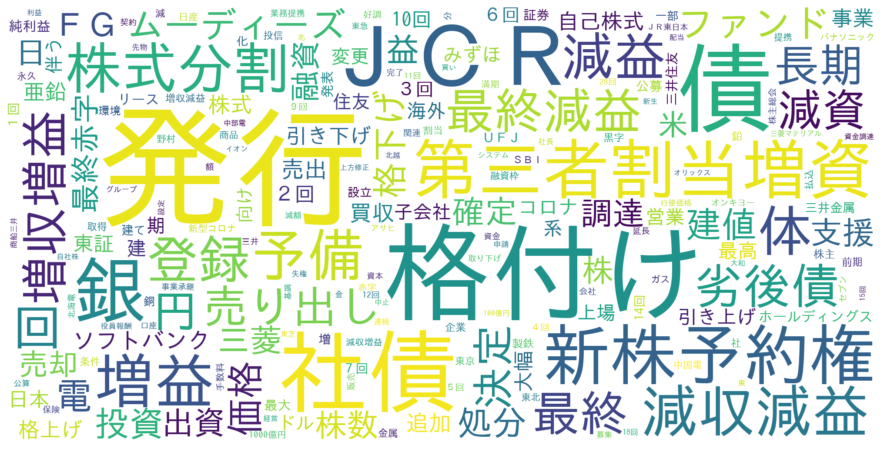

### cluster=7 (+)

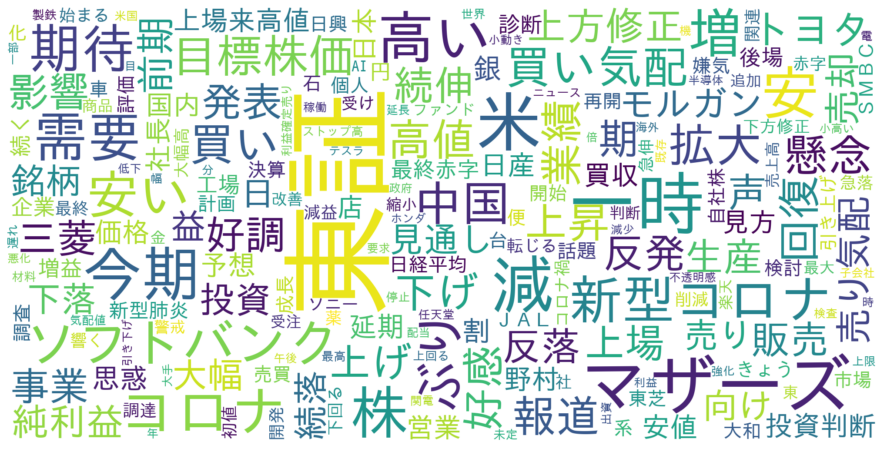

In [41]:
display_markdown('### cluster=4 (-)', raw=True)
display_wordcloud(tagger=owakati, texts=df_target[df_target['labels']==4]['headline'], stopwords=stopwords, collocations=False)
display_markdown('### cluster=7 (+)', raw=True)
display_wordcloud(tagger=owakati, texts=df_target[df_target['labels']==7]['headline'], stopwords=stopwords, collocations=False)

## scatter text
⇒処理が重い為、断念。(メモリ不足?)

In [ ]:
import scattertext as st

tagger = owakati
tokenized = df_target['headline'].apply(lambda x: tagger.parse(x).strip("\n").rstrip())

# 確認する
display(tokenized.head(3))

In [ ]:
parsed = tokenized.apply(st.whitespace_nlp_with_sentences)

# 確認する
display(parsed.head(3))

In [ ]:
corpus = st.CorpusWithoutCategoriesFromParsedDocuments(
    parsed.rename('parse').to_frame(), parsed_col='parse'
).build().get_unigram_corpus().remove_terms(stopwords, ignore_absences=True).remove_infrequent_words(minimum_term_count=100)

dispersion = st.Dispersion(corpus)
dispersion_df = dispersion.get_df()

# ビルドされた頻度情報及び使用分布情報から、どの基準を用いてプロットするかをX, Xpos, Y, Yposのcolumnsにセットする。
dispersion_df = dispersion_df.assign(
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df["Rosengren's S"],
    Ypos=lambda df: st.Scalers.scale(df.Y),
)

# 確認する
dispersion_df.head(5)

## 取引戦略
クラスター7に含まれる銘柄から何個かをピックアップするという戦略が考えられる。  

## 検証③：テスト  
2021年1月1日～4月1日までのニュースに対して検証。
* テスト期間におけるセクター毎のリターン
* テスト期間におけるクラスター毎のリターン

### テスト(セクター分析)

In [42]:
# 文章の特徴量を読込み
new_headline_features = pd.read_pickle('../data/new_headline_features.pkl') 
new_headline_features.columns = [f'feature_{i}' for i in new_headline_features.columns]

# 検証用の記事一覧を読み込む
df_new_article = pd.read_csv('../data/new_article.csv', index_col=[0])

# 文章の特徴量と元データをリンクさせる
df_new_article.dropna(subset=['headline', 'keywords'], inplace=True)

# headlineもしくは、keywordsどちらかで人事を含むニュース記事のindexマスクを作成。
drop_mask = df_new_article['headline'].str.contains('人事') | df_new_article['keywords'].str.contains('人事')

# '人事'を含む行を除外する
df_new_article = df_new_article[~drop_mask].copy()

# 結合する
df_new_article = pd.concat([df_new_article.reset_index(drop=True), new_headline_features.reset_index(drop=True)], axis=1).copy()

# 2021年1月1日～4月1日までにニュースが存在する銘柄の株価
df_new_price = pd.read_csv('../data/new_stock_price.csv', index_col=[0])

# company_g.stock_codeが存在するもののみを対象とする
df_new_target = df_new_article[df_new_article['stock_code'].isin(codes)].copy()

df_new_target['publish_datetime'] = pd.to_datetime(df_new_target['publish_datetime'])
df_new_target['publish_datetime'] = df_new_target['publish_datetime'].apply(convert_datetime)

df_new_price.set_index('EndOfDayQuote Date', inplace=True)
df_new_price.index = pd.to_datetime(df_new_price.index)

returns = {'1days':[], '5days':[], '20days':[]}

for i in df_new_target.index:
    # 対象銘柄の価格情報
    df_price_one_code = df_new_price[df_new_price['Local Code'] == int(df_new_target['stock_code'][i])]

    # ニュース公表日以降を取り出し
    mask = df_price_one_code.index >= pd.to_datetime(df_new_target['publish_datetime'][i].date())
    df_price_one_code = df_price_one_code[mask]

    # 各リターンを格納する
    for key, num in zip(returns.keys(), [1, 5, 20]):
        try:
            returns[key].append(df_price_one_code['EndOfDayQuote ExchangeOfficialClose'].pct_change(num).dropna()[0])
        except:
            returns[key].append(np.nan)

df_new_target['1days_R'] = returns['1days']
df_new_target['5days_R'] = returns['5days']
df_new_target['20days_R'] = returns['20days']

display(df_new_target.head(3))

article_id          publish_datetime media_code  \
7   TDSKDBDGXZQOFB285XI028012021000000 2021-02-01 15:00:00+00:00        TNY   
11  TDSKDBDGXLRSP604201_01022021000000 2021-02-01 15:00:00+00:00        TNY   
16  TDSKDBDGXZQODZ16B23016122020000000 2021-01-03 15:00:00+00:00        TNY   

   media_name  men_name                                  headline  \
7   日本経済新聞電子版       NaN                  首都圏の地銀・信金、夜間金庫のサービス終了広がる   
11  日本経済新聞電子版       NaN              エーザイ、パーキンソン病治療剤「エクフィナ」を韓国で発売   
16  日本経済新聞電子版       NaN  通販を「Amazonスルー」に　消費者と小売り直結\nポストGAFAの胎動（2）   

                                             keywords  \
7                 サービス終了\n信用金庫\n地方銀行\n城南信用金庫\n金庫\n首都圏   
11  新製品\nエクフィナ\n内藤晴夫\n韓国\nエーザイ\nパーキンソン病治療剤\nエーザイ・コ...   
16  アマゾンジャパン\nアマゾン・ドット・コム\nショッピファイ\nジャック・ドーシー\nスクエ...   

                                      classifications stock_code  feature_0  \
7   ＄絵写表記事\nＴ８３３７\nＰＤ４７３\nＮ００７００３４\n＄地域\n＄東京\n＄関東\...       8337   0.167979   
11  Ｔ４５２３\nＰＤ０９２\nＮ００００６１１\n＃Ｗ１０２０９\n＃Ｗ１０２０１\n＃Ａ４１...       4523   0.287937   
16  ＄絵写表記事\nＴ９９８３\nＰＤ４５４\nＮ００１６１６６\n＄地域\n＄中国\n＄ビジネ...       9983  -0.165007   

    ...  feature_761  feature_762  feature_763  feature_764  feature_765  \
7   ...     0.071291     0.174647     0.185721     0.200714    -0.146291   
11  ...    -0.058853     0.459766    -0.198747     0.447848    -0.290881   
16  ...    -0.080301     0.500809     0.078737     0.134524     0.052887   

    feature_766  feature_767   1days_R   5days_R  20days_R  
7     -0.496031     0.252382  0.008439  0.088608  0.084388  
11    -0.233987    -0.118387 -0.011421  0.002566 -0.050430  
16    -0.094063     0.272777 -0.020648  0.000659  0.005052  

[3 rows x 780 columns]

In [65]:
# ニュースと業種を紐づける
df_new_target.rename(columns={'Local Code':'stock_code'}, inplace=True)
stock_list.rename(columns={'Local Code':'stock_code'}, inplace=True)
stock_list['stock_code'] = stock_list['stock_code'].astype(str) 

df_new_target = pd.merge(df_new_target, stock_list[['stock_code', '33 Sector(Code)', '17 Sector(Code)']], on='stock_code')
display(df_new_target.head(3))

article_id          publish_datetime media_code  \
0  TDSKDBDGXZQOFB285XI028012021000000 2021-02-01 15:00:00+00:00        TNY   
1  TDSKDBDGXZQOFB059HC005022021000000 2021-02-08 15:00:00+00:00        TNY   
2  TDSKDBDGXLRSP604201_01022021000000 2021-02-01 15:00:00+00:00        TNY   

  media_name  men_name                      headline  \
0  日本経済新聞電子版       NaN      首都圏の地銀・信金、夜間金庫のサービス終了広がる   
1  日本経済新聞電子版       NaN    千葉興業銀行、実質業務純益3%減　20年4～12月期   
2  日本経済新聞電子版       NaN  エーザイ、パーキンソン病治療剤「エクフィナ」を韓国で発売   

                                            keywords  \
0                サービス終了\n信用金庫\n地方銀行\n城南信用金庫\n金庫\n首都圏   
1                          千葉興業銀行\n実質\n業務純益\n減益\n純利益   
2  新製品\nエクフィナ\n内藤晴夫\n韓国\nエーザイ\nパーキンソン病治療剤\nエーザイ・コ...   

                                     classifications stock_code  feature_0  \
0  ＄絵写表記事\nＴ８３３７\nＰＤ４７３\nＮ００７００３４\n＄地域\n＄東京\n＄関東\...       8337   0.167979   
1  Ｔ８３３７\nＰＤ４７３\nＮ００７００３４\n＄地域\n＄千葉\n＄地域金融\n＃Ｗ１０５...       8337  -0.331890   
2  Ｔ４５２３\nＰＤ０９２\nＮ００００６１１\n＃Ｗ１０２０９\n＃Ｗ１０２０１\n＃Ａ４１...       4523   0.287937   

   ...  feature_763  feature_764  feature_765  feature_766  feature_767  \
0  ...     0.185721     0.200714    -0.146291    -0.496031     0.252382   
1  ...    -0.289625     0.339395    -0.193994    -0.875307    -0.239374   
2  ...    -0.198747     0.447848    -0.290881    -0.233987    -0.118387   

    1days_R   5days_R  20days_R  33 Sector(Code)  17 Sector(Code)  
0  0.008439  0.088608  0.084388             7050               15  
1 -0.015504  0.007752  0.046512             7050               15  
2 -0.011421  0.002566 -0.050430             3250                5  

[3 rows x 782 columns]

In [69]:
# 各セクターのリターンを算出
display(df_new_target.groupby('17 Sector(Code)').mean()[['1days_R', '5days_R', '20days_R']])
display(df_t_result[df_t_result['p-value'] < 0.05]) # 学習期間を再掲

1days_R   5days_R  20days_R
17 Sector(Code)                              
1                0.002952  0.004085  0.007150
2                0.002001  0.006084  0.071286
3                0.000332  0.008020  0.040662
4                0.002513  0.008596  0.027662
5                0.000503  0.004818 -0.009335
6                0.002857  0.012098  0.044584
7                0.004105  0.021076  0.099588
8                0.002833  0.004170  0.033334
9                0.003278  0.012469  0.034891
10               0.002726  0.012885  0.039535
11               0.002769  0.009063  0.013625
12               0.003358  0.012116  0.040233
13               0.002168  0.010028  0.039984
14               0.002867  0.007624  0.022423
15               0.002131  0.012406  0.040062
16               0.003844  0.013067  0.041314
17               0.002000  0.013035  0.039534

t       p-value  samples
sector2  ENERGY RESOURCES            -3.192601  1.720294e-03      150
sector4  RAW MATERIALS & CHEMICALS    3.461495  5.499150e-04     1775
sector5  PHARMACEUTICAL               2.277410  2.308524e-02      652
sector7  STEEL & NONFERROUS METALS    2.994656  2.886247e-03      492
sector11 ELECTRIC POWER & GAS        -3.392699  7.391683e-04      582
sector12 TRANSPORTATION & LOGISTICS  -2.285362  2.242262e-02     1592
sector15 BANKS                       -6.094757  1.513684e-09     1102

### テスト(クラスタリング)

In [75]:
predict = kmeans_model.predict(df_new_target.loc[:, df_new_target.columns.str.contains('feature_')])
df_new_target['labels'] = predict
display(df_new_target.head(3))

article_id          publish_datetime media_code  \
0  TDSKDBDGXZQOFB285XI028012021000000 2021-02-01 15:00:00+00:00        TNY   
1  TDSKDBDGXZQOFB059HC005022021000000 2021-02-08 15:00:00+00:00        TNY   
2  TDSKDBDGXLRSP604201_01022021000000 2021-02-01 15:00:00+00:00        TNY   

  media_name  men_name                      headline  \
0  日本経済新聞電子版       NaN      首都圏の地銀・信金、夜間金庫のサービス終了広がる   
1  日本経済新聞電子版       NaN    千葉興業銀行、実質業務純益3%減　20年4～12月期   
2  日本経済新聞電子版       NaN  エーザイ、パーキンソン病治療剤「エクフィナ」を韓国で発売   

                                            keywords  \
0                サービス終了\n信用金庫\n地方銀行\n城南信用金庫\n金庫\n首都圏   
1                          千葉興業銀行\n実質\n業務純益\n減益\n純利益   
2  新製品\nエクフィナ\n内藤晴夫\n韓国\nエーザイ\nパーキンソン病治療剤\nエーザイ・コ...   

                                     classifications stock_code  feature_0  \
0  ＄絵写表記事\nＴ８３３７\nＰＤ４７３\nＮ００７００３４\n＄地域\n＄東京\n＄関東\...       8337   0.167979   
1  Ｔ８３３７\nＰＤ４７３\nＮ００７００３４\n＄地域\n＄千葉\n＄地域金融\n＃Ｗ１０５...       8337  -0.331890   
2  Ｔ４５２３\nＰＤ０９２\nＮ００００６１１\n＃Ｗ１０２０９\n＃Ｗ１０２０１\n＃Ａ４１...       4523   0.287937   

   ...  feature_764  feature_765  feature_766  feature_767   1days_R  \
0  ...     0.200714    -0.146291    -0.496031     0.252382  0.008439   
1  ...     0.339395    -0.193994    -0.875307    -0.239374 -0.015504   
2  ...     0.447848    -0.290881    -0.233987    -0.118387 -0.011421   

    5days_R  20days_R  33 Sector(Code)  17 Sector(Code)  labels  
0  0.088608  0.084388             7050               15       4  
1  0.007752  0.046512             7050               15       0  
2  0.002566 -0.050430             3250                5       6  

[3 rows x 783 columns]

<AxesSubplot:xlabel='labels'>

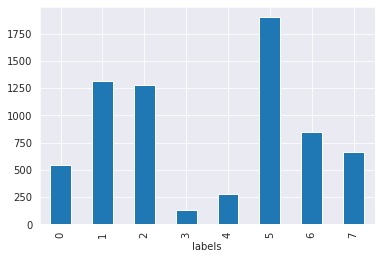

In [81]:
df_new_target.groupby('labels').count()['article_id'].plot.bar()

クラスター4に属するデータは少ない。  
クラスター4はネガティブなニュース群であったが、2021年からは社会情勢も変わり景気がよくなっている(日経平均は上昇)ことから  
データ数が少なくなったのかもしれない。  
クラスター7についてはそこそこのデータ数を確保できている。  
⇒それぞれのクラスターについて、上記の分析と同様にwordcloudからニュースの概要を見てみる。

### cluster=4 (-)

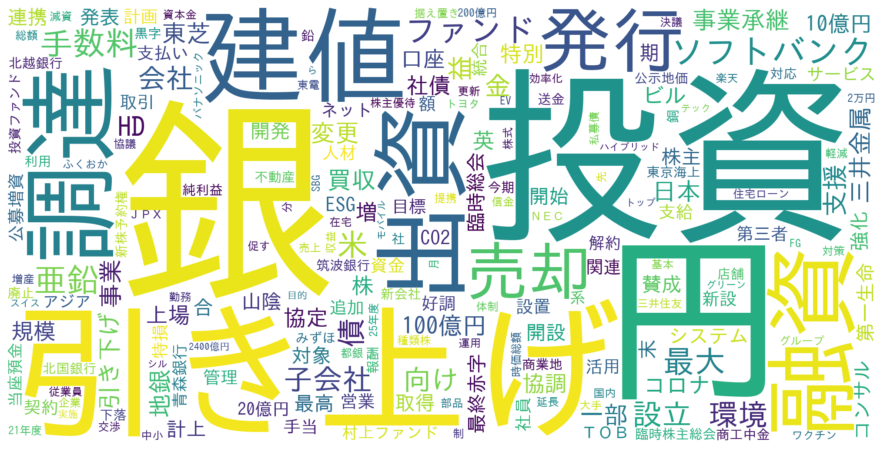

### cluster=7 (+)

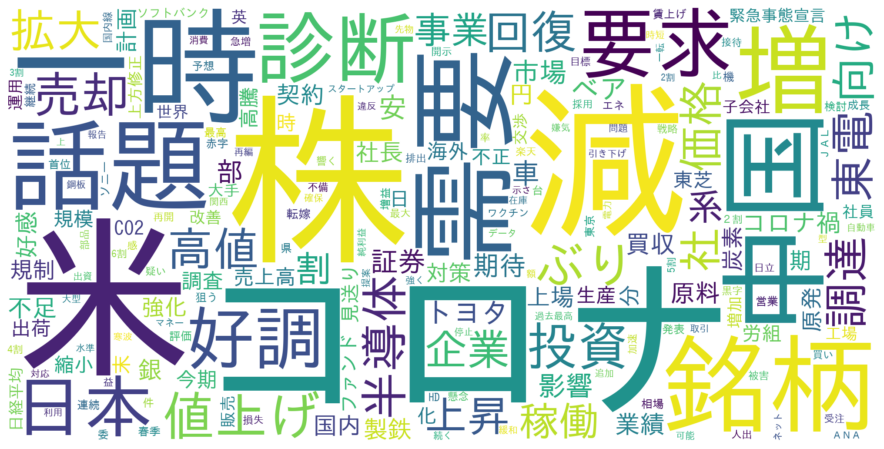

In [84]:
display_markdown('### cluster=4 (-)', raw=True)
display_wordcloud(tagger=owakati, texts=df_new_target[df_new_target['labels']==4]['headline'], stopwords=stopwords, collocations=False)
display_markdown('### cluster=7 (+)', raw=True)
display_wordcloud(tagger=owakati, texts=df_new_target[df_new_target['labels']==7]['headline'], stopwords=stopwords, collocations=False)

<クラスター4>  
ニュースの内容が好転しているように感じられる。  
「引き上げ」が目立つようにコロナ禍で先行きが不透明だったものが、不透明感がなくなり業績を引き上げる企業が増えたのかもしれない。

<クラスター7>  
上での分析同様にコロナという単語が目立つ。  
ポジティブなニュースを含むように見えるが、コロナに敏感な銘柄が集まっている可能性がある。  
他のクラスターでも「コロナ」を含むかは確認したほうが良さそうである。  
下の結果を見る限り、「コロナ」に引っ張られている様子はなさそう。

### cluster=0

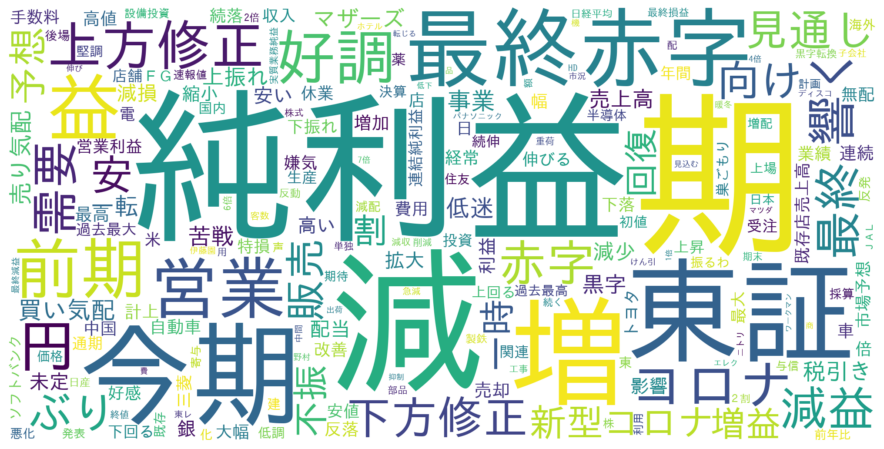

### cluster=1

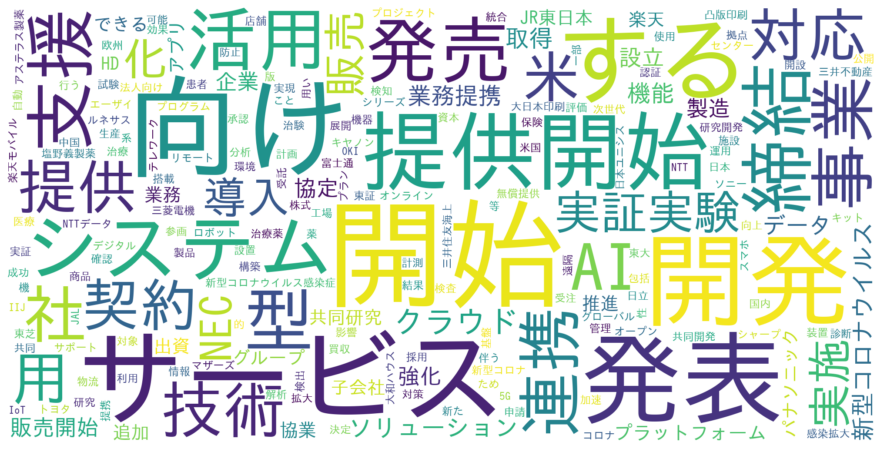

### cluster=2

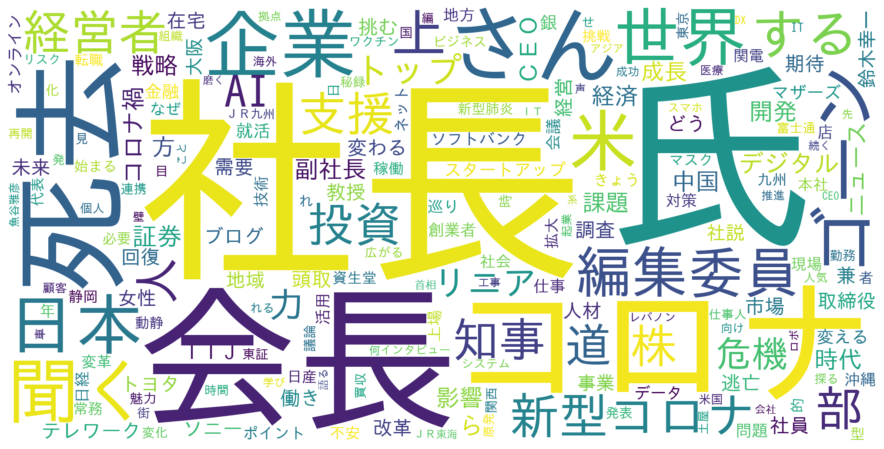

### cluster=3

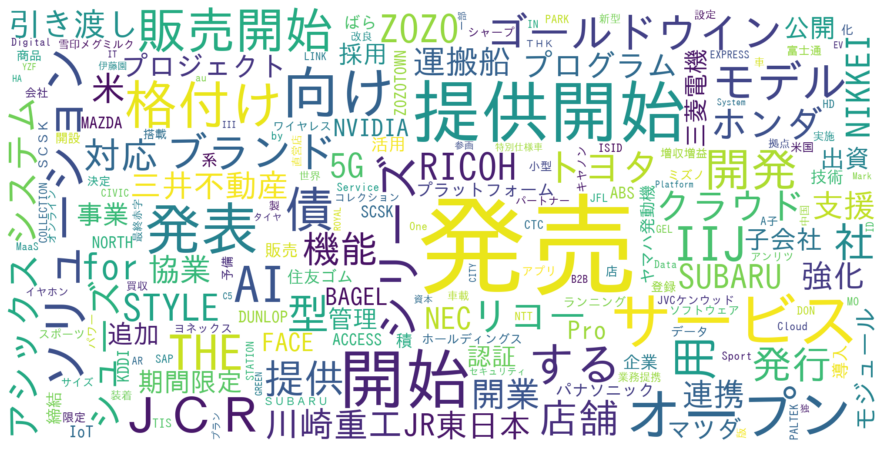

### cluster=4

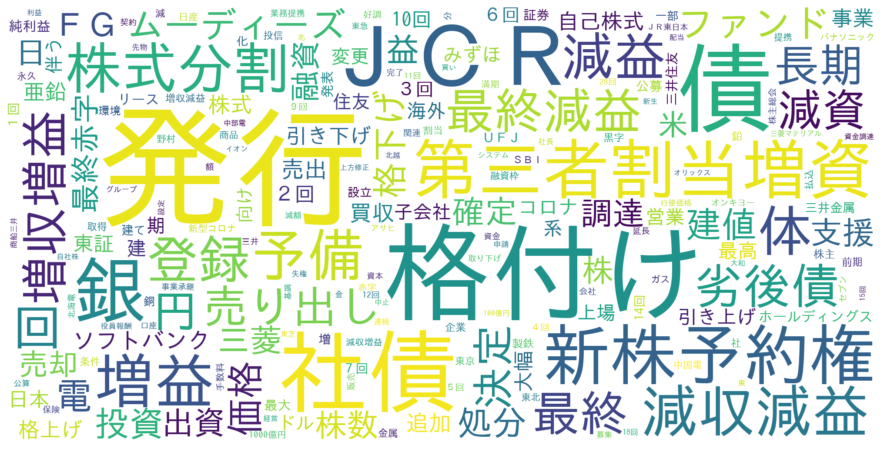

### cluster=5

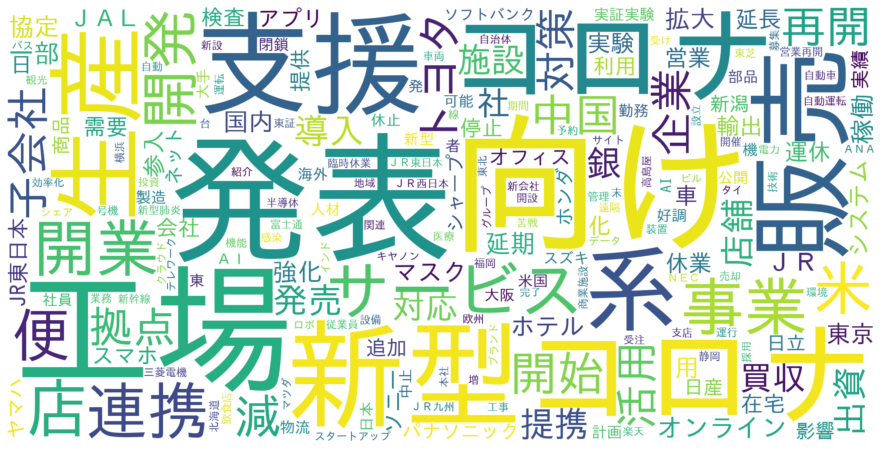

### cluster=6

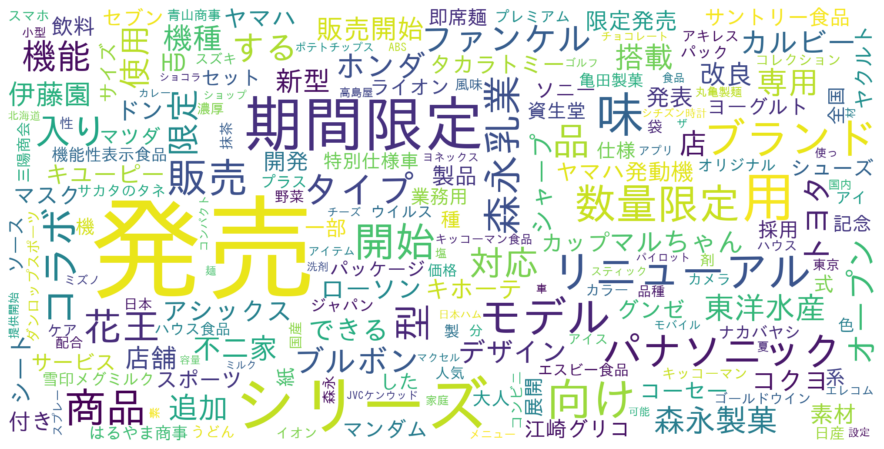

### cluster=7

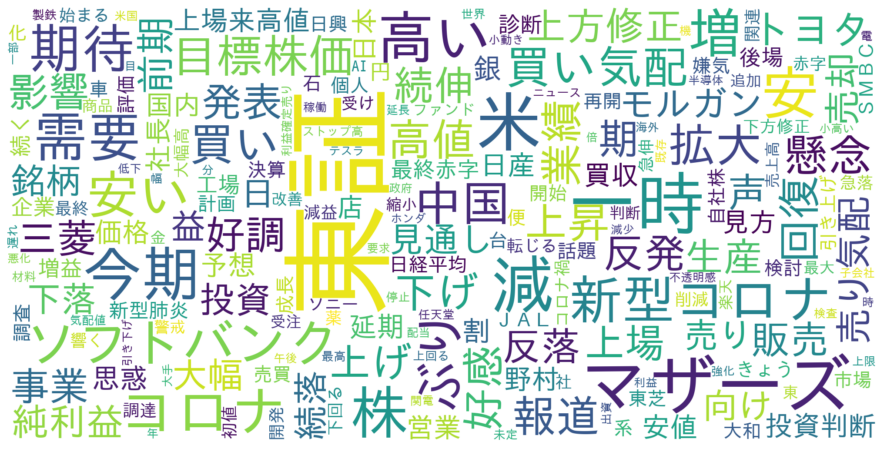

In [85]:
for i in range(8):
    display_markdown(f'### cluster={i}', raw=True)
    display_wordcloud(tagger=owakati, texts=df_target[df_target['labels']==i]['headline'], stopwords=stopwords, collocations=False)

In [88]:
df_new_target = df_new_target.replace([np.inf, -np.inf], np.nan).copy()
df_new_target_cluster = df_new_target[['1days_R', '5days_R', '20days_R', 'labels']]
display_markdown('### Return maean', raw=True)
display(df_new_target_cluster.groupby('labels').mean())
display_markdown('### Smple num', raw=True)
display(df_new_target_cluster.groupby('labels').count())

### Return maean

1days_R   5days_R  20days_R
labels                              
0       0.001120  0.008121  0.035831
1       0.002468  0.012064  0.035584
2       0.002648  0.011120  0.031489
3       0.004621  0.013242  0.046659
4       0.002789  0.013605  0.036959
5       0.002662  0.009610  0.033563
6       0.002606  0.007637  0.023993
7       0.004935  0.015002  0.045097

### Smple num

1days_R  5days_R  20days_R
labels                            
0           544      544       537
1          1313     1313      1303
2          1274     1274      1247
3           128      128       124
4           278      278       268
5          1899     1899      1855
6           851      850       840
7           664      664       653

In [92]:
# 検定:各クラスターの平均μ=0
t_p = {}
for i in range(8):
    df_one_cluster = df_new_target_cluster[df_new_target_cluster['labels'] == i]
    for n in [1, 5, 20]:
        R_n = df_one_cluster[f'{n}days_R'].dropna()
        t_p[(i, f'{n}days_R')] = stats.ttest_1samp(R_n / R_n.std(), 0)

df_new_tp = pd.DataFrame(t_p)
df_new_tp.index = ['t', 'p']
df_new_tp = df_new_tp.T.unstack()
df_new_tp

t                                  p                            
    1days_R   20days_R   5days_R       1days_R      20days_R       5days_R
0  0.964701   8.640905  3.497971  3.351240e-01  6.438562e-17  5.072387e-04
1  3.987844  13.364037  8.212124  7.035497e-05  2.875392e-38  5.150377e-16
2  4.258905  11.926030  7.794589  2.205335e-05  3.981694e-31  1.335233e-14
3  1.971276   4.870433  2.550221  5.086653e-02  3.351061e-06  1.195344e-02
4  1.861499   5.715882  4.476078  6.373289e-02  2.912847e-08  1.111712e-05
5  5.183309  14.098621  8.308276  2.411772e-07  5.898098e-43  1.824186e-16
6  3.603734   7.338649  5.039210  3.319139e-04  5.097832e-13  5.713484e-07
7  4.442431  10.838987  7.000836  1.042156e-05  2.772458e-25  6.250810e-12

In [94]:
df_new_target_cluster_mean = df_new_target_cluster.groupby('labels').mean()
display(df_new_target_cluster_mean)
display(df_new_target_cluster_mean[df_new_tp['p']<0.05])

1days_R   5days_R  20days_R
labels                              
0       0.001120  0.008121  0.035831
1       0.002468  0.012064  0.035584
2       0.002648  0.011120  0.031489
3       0.004621  0.013242  0.046659
4       0.002789  0.013605  0.036959
5       0.002662  0.009610  0.033563
6       0.002606  0.007637  0.023993
7       0.004935  0.015002  0.045097

1days_R   5days_R  20days_R
labels                              
0            NaN  0.008121  0.035831
1       0.002468  0.012064  0.035584
2       0.002648  0.011120  0.031489
3            NaN  0.013242  0.046659
4            NaN  0.013605  0.036959
5       0.002662  0.009610  0.033563
6       0.002606  0.007637  0.023993
7       0.004935  0.015002  0.045097

<結果>  
テスト期間においてクラスター4・7ともにプラスのリターンとなった。  
クラスター4では上で述べたように内容が好転した結果、リターンはマイナス傾向からプラス傾向になったように思われる。  
クラスター7については、上での分析時点と同様に正のリターンが得られた。しかも他のクラスターに比べてかなり高いリターンとなっている。  　　
以上を踏まえて、クラスター7に含まれる銘柄を選択する戦略としていく。  
* 直近の20日間のニュースでクラスター7に属する銘柄に投資する
* 投資比率は直近程のものを程、投資比率を上げる？
* 各業種の週次リターンを予測して、それに基づき分配してもよい。(クラスター7の銘柄構成による)
* ~写真がある場合は比率を上げる~

クラスター7に属する銘柄の特徴を見る必要がある。  
* 業種に偏りはないか
* 銘柄に偏りはないか 等

## クラスター7について

In [117]:
df_cluster7 = df_target[df_target['labels'] == 7].copy()
df_cluster7.rename(columns={'company_g.stock_code':'stock_code'}, inplace=True)
df_cluster7 = pd.merge(df_cluster7, stock_list[['stock_code', '33 Sector(Code)', '17 Sector(Code)']], on='stock_code')
display(df_cluster7.head(3))

article_id          publish_datetime media_code  \
0  TDSKDBDGXMZO5378396025122019FFE000 2020-01-01 15:00:00+09:00        TNY   
1  TDSKDBDGXLASFL04H8A_04022020000000 2020-02-04 15:00:00+09:00        TNY   
2  TDSKDBDGXMZO5523176004022020EN1000 2020-02-05 15:00:00+09:00        TNY   

  media_name  men_name  page_from picture_flag  paragraph_cnt  char_length  \
0  日本経済新聞電子版       NaN        NaN            有             18         2171   
1  日本経済新聞電子版       NaN        NaN          NaN              4          547   
2  日本経済新聞電子版       NaN        NaN            有              6          550   

                         headline  ... feature_764 feature_765 feature_766  \
0           中国、冷えるＥＶ電池市場　日韓と競争激しく  ...    0.685178   -0.014371    0.258831   
1  ＜東証＞パナソニックが大幅高　車載電池事業の黒字定着に期待感  ...    0.568831   -0.016700   -0.411057   
2         パナソニック、昨年来高値　４～12月決算を好感  ...    0.919228    0.026404   -0.194681   

   feature_767   1days_R   5days_R  20days_R  labels  33 Sector(Code)  \
0    -0.128394  0.028010  0.040295  0.163145       7             3650   
1    -0.217340  0.043515  0.041825 -0.145332       7             3650   
2    -0.366497  0.013360 -0.007287 -0.216518       7             3650   

   17 Sector(Code)  
0                9  
1                9  
2                9  

[3 rows x 787 columns]

<AxesSubplot:xlabel='17 Sector(Code)'>

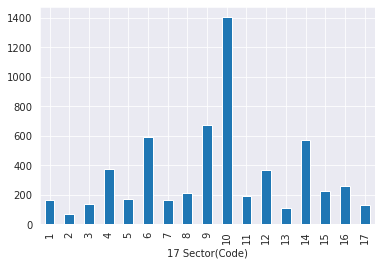

In [119]:
df_cluster7.groupby('17 Sector(Code)').count()['article_id'].plot.bar()

特に特定の業種に偏っているというわけではなく、ニュースの発行数に応じて分布しているように見える。

In [143]:
df_appear_freq = pd.DataFrame((df_cluster7.groupby('stock_code').count()['article_id'] / len(df_cluster7)))
df_appear_freq.columns = ['freq_rate']
df_appear_freq = df_appear_freq.sort_values(by='freq_rate', ascending=False)
df_appear_freq = pd.merge(
                          df_appear_freq, stock_list, left_on='stock_code', right_on='stock_code'
                          )[['stock_code', 'Name (English)', '17 Sector(Code)', '17 Sector(name)', 'freq_rate']]
display(df_appear_freq.head(10))

stock_code                                  Name (English)  17 Sector(Code)  \
0       9984                            SoftBank Group Corp.               10   
1       7203                        TOYOTA MOTOR CORPORATION                6   
2       9201                         Japan Airlines Co.,Ltd.               12   
3       7201                           NISSAN MOTOR CO.,LTD.                6   
4       6758                                SONY CORPORATION                9   
5       5401                        NIPPON STEEL CORPORATION                7   
6       4755                                    Rakuten,Inc.               10   
7       6502                             TOSHIBA CORPORATION                9   
8       7267                            HONDA MOTOR CO.,LTD.                6   
9       9503  The Kansai Electric Power Company,Incorporated               11   

                                17 Sector(name)  freq_rate  
0                        IT & SERVICES, OTHERS    0.056474  
1       AUTOMOBILES & TRANSPORTATION EQUIPMENT    0.042700  
2                   TRANSPORTATION & LOGISTICS    0.019628  
3       AUTOMOBILES & TRANSPORTATION EQUIPMENT    0.019456  
4  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS    0.013085  
5                    STEEL & NONFERROUS METALS    0.012052  
6                        IT & SERVICES, OTHERS    0.011708  
7  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS    0.011364  
8       AUTOMOBILES & TRANSPORTATION EQUIPMENT    0.011191  
9                         ELECTRIC POWER & GAS    0.010847

やはり、有名企業が上位は目立つ。  
この中だと、セクター11の関電やセクター12の日本航空や含めないようにしたほうが賢明である。(以下の表や最近のニュースを見ると)  
ただ、業績回復のようなニュースを捉えることができるのなら含めることでリターンを得るチャンスがある。  
業界ごとの週次予測指標を利用するか最初からリターンが負のセクター(2, 11, 12, 15)を除外するか。

In [144]:
# 有意水準5％以下だけにする
display(df_t_result[df_t_result['p-value'] < 0.05])

t       p-value  samples
sector2  ENERGY RESOURCES            -3.192601  1.720294e-03      150
sector4  RAW MATERIALS & CHEMICALS    3.461495  5.499150e-04     1775
sector5  PHARMACEUTICAL               2.277410  2.308524e-02      652
sector7  STEEL & NONFERROUS METALS    2.994656  2.886247e-03      492
sector11 ELECTRIC POWER & GAS        -3.392699  7.391683e-04      582
sector12 TRANSPORTATION & LOGISTICS  -2.285362  2.242262e-02     1592
sector15 BANKS                       -6.094757  1.513684e-09     1102

負のセクター除外前後でリターンの変化を見てみる。

In [160]:
display_markdown('#### before', raw=True)
display(df_cluster7[['1days_R', '5days_R', '20days_R']].mean())

display_markdown('#### after', raw=True)
display_markdown('##### sector=4, 5, 7 (+)', raw=True)
df_cluster7_pos = df_cluster7.loc[df_cluster7['17 Sector(Code)'].isin([4, 5, 7])]
display(df_cluster7_pos[['1days_R', '5days_R', '20days_R']].mean())

display_markdown('##### sector=2, 11, 12, 15 (-)', raw=True)
df_cluster7_neg = df_cluster7.loc[df_cluster7['17 Sector(Code)'].isin([2, 11, 12, 15])]
display(df_cluster7_neg[['1days_R', '5days_R', '20days_R']].mean())

display_markdown('##### sector!=2, 11, 12, 15 (+?)', raw=True)
df_cluster7_rm_neg = df_cluster7.loc[~df_cluster7['17 Sector(Code)'].isin([2, 11, 12, 15])]
display(df_cluster7_rm_neg[['1days_R', '5days_R', '20days_R']].mean())


#### before

1days_R     0.004378
5days_R     0.008336
20days_R    0.010476
dtype: float64

#### after

##### sector=4, 5, 7 (+)

1days_R     0.000286
5days_R    -0.001244
20days_R   -0.003475
dtype: float64

##### sector=2, 11, 12, 15 (-)

1days_R    -0.001236
5days_R    -0.008317
20days_R   -0.004838
dtype: float64

##### sector!=2, 11, 12, 15 (+?)

1days_R     0.005345
5days_R     0.011197
20days_R    0.013071
dtype: float64

### テストデータに対してみておく

article_id          publish_datetime media_code  \
22  TDSKDBDGXZQODZ0447S004012021000000 2021-01-06 15:00:00+00:00        TNY   
30  TDSKDBDGXZQODZ134RP013012021000000 2021-01-15 15:00:00+00:00        TNY   
32  TDSKDBDGXZQODZ040L1004032021000000 2021-03-04 15:00:00+00:00        TNY   

   media_name  men_name                      headline  \
22  日本経済新聞電子版       NaN      ユニクロ国内販売、12月は6.2％増　防寒着好調   
30  日本経済新聞電子版       NaN     ファストリ、コロナ下の最高益へ　国内ユニクロが好調   
32  日本経済新聞電子版       NaN  ファストリ9%値下げ　12日から税別価格そのまま税込みに   

                                             keywords  \
22                          ヒートテック\nユニクロ\n国内販売\n防寒着好調   
30  コロナ下\nファーストリテイリング\nユニクロ\n営業利益\n国内\n好調\n岡崎健\n最高...   
32                ファーストリテイリング\n価格\n値下げ\n税別\n税込み\nｇ．ｕ．   

                                      classifications stock_code  feature_0  \
22  ＄絵写表記事\nＴ９９８３\nＰＤ４５４\nＮ００１６１６６\n＄ビジネス\n＄小売り・外食...       9983   0.062224   
30  ＄絵写表記事\nＴ９９８３\nＰＤ４５４\nＮ００１６１６６\n＄ビジネス\n＄小売り・外食...       9983  -0.115004   
32  ＄絵写表記事\nＴ９９８３\nＰＤ４５４\nＮ００１６１６６\n＄ビジネス\n＄小売り・外食...       9983   0.176126   

    ...  feature_764  feature_765  feature_766  feature_767   1days_R  \
22  ...     0.622628     0.137930    -0.217711     0.284377  0.015984   
30  ...     0.339429    -0.046807     0.164910     0.130530 -0.008572   
32  ...     0.211294    -0.118117    -0.129049     0.242596 -0.033861   

     5days_R  20days_R  33 Sector(Code)  17 Sector(Code)  labels  
22  0.077047  0.046688             6100               14       7  
30  0.009122  0.093087             6100               14       7  
32 -0.044341 -0.113575             6100               14       7  

[3 rows x 783 columns]

<AxesSubplot:xlabel='17 Sector(Code)'>

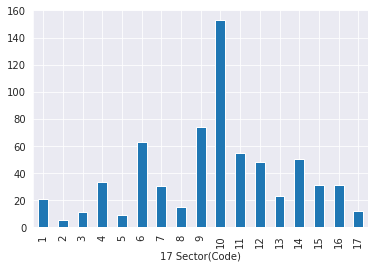

In [168]:
df_new_cluster7 = df_new_target[df_new_target['labels'] == 7].copy()
df_new_cluster7.rename(columns={'company_g.stock_code':'stock_code'}, inplace=True)
display(df_new_cluster7.head(3))
df_new_cluster7.groupby('17 Sector(Code)').count()['article_id'].plot.bar()

In [169]:
display_markdown('#### before', raw=True)
display(df_new_cluster7[['1days_R', '5days_R', '20days_R']].mean())

display_markdown('#### after', raw=True)
display_markdown('##### sector=4, 5, 7 (+)', raw=True)
df_new_cluster7_pos = df_new_cluster7.loc[df_new_cluster7['17 Sector(Code)'].isin([4, 5, 7])]
display(df_new_cluster7_pos[['1days_R', '5days_R', '20days_R']].mean())

display_markdown('##### sector=2, 11, 12, 15 (-)', raw=True)
df_new_cluster7_neg = df_new_cluster7.loc[df_new_cluster7['17 Sector(Code)'].isin([2, 11, 12, 15])]
display(df_new_cluster7_neg[['1days_R', '5days_R', '20days_R']].mean())

display_markdown('##### sector!=2, 11, 12, 15 (+?)', raw=True)
df_new_cluster7_rm_neg = df_new_cluster7.loc[~df_new_cluster7['17 Sector(Code)'].isin([2, 11, 12, 15])]
display(df_new_cluster7_rm_neg[['1days_R', '5days_R', '20days_R']].mean())


#### before

1days_R     0.004935
5days_R     0.015002
20days_R    0.045097
dtype: float64

#### after

##### sector=4, 5, 7 (+)

1days_R     0.001177
5days_R     0.007598
20days_R    0.065676
dtype: float64

##### sector=2, 11, 12, 15 (-)

1days_R     0.003517
5days_R     0.013257
20days_R    0.041034
dtype: float64

##### sector!=2, 11, 12, 15 (+?)

1days_R     0.005310
5days_R     0.015464
20days_R    0.046165
dtype: float64

セクター2, 11, 12, 15 を除外するとリターンは向上する傾向がある。

In [177]:
# 写真の有無について
display_markdown('### train', raw=True)
display_markdown('#### All', raw=True)
display(df_cluster7_rm_neg[['1days_R', '5days_R', '20days_R']].mean())
display_markdown('#### with pictures', raw=True)
display(df_cluster7_rm_neg.dropna(subset=['picture_flag'])[['1days_R', '5days_R', '20days_R']].mean())

display_markdown('### test', raw=True)
display_markdown('#### All', raw=True)
display(df_new_cluster7_rm_neg[['1days_R', '5days_R', '20days_R']].mean())
display_markdown('#### with pictures', raw=True)
display(df_new_cluster7_rm_neg.dropna(subset=['picture_flag'])[['1days_R', '5days_R', '20days_R']].mean())

### train

#### All

1days_R     0.005345
5days_R     0.011197
20days_R    0.013071
dtype: float64

#### with pictures

1days_R     0.001319
5days_R     0.002423
20days_R    0.010421
dtype: float64

### test

#### All

1days_R     0.005310
5days_R     0.015464
20days_R    0.046165
dtype: float64

#### with pictures

KeyError: ['picture_flag']

picture_flagはテストデータに含まれていなかった為、検証不可。(APIから取得できるのかもしれないが)    
学習期間の時点で写真有のみに絞っても効果がなさそうなので今回は写真の有無については特に問わないことにする。

In [22]:
# modelを保存しておく
import pickle
with open('../model/kmeans_model.pickle', mode='wb') as fp:
    pickle.dump(kmeans_model, fp)

In [28]:
with open('../model/kmeans_model.pickle', mode='rb') as fp:
    kmeans_model2 = pickle.load(fp)

tmp = kmeans_model2.predict(df_target.loc[:, df_target.columns.str.contains('feature_')])
print(min(tmp), max(tmp), np.mean(tmp))

0 7 3.706058136375985
